https://github.com/mohamedelhakim/Transformer-CNN-Architecture

# Import modules

The hybrid model combines a Convolutional Neural Network (CNN) and a Transformer to classify ECG signals. The CNN first extracts local features from the input signal, capturing patterns like peaks and troughs. The output of the CNN is then passed to a Transformer, which processes these features to capture long-range dependencies, learning relationships between distant points in the signal. This approach leverages the strengths of both architectures: the CNN’s ability to focus on local patterns and the Transformer’s capacity to understand global context. The final output is a classification of the ECG signal, benefiting from both local and global feature learning.

In [2]:
import pandas as pd
import numpy as np
import os
import copy
import math

import torch
from torch import nn, optim
import torch.nn.functional as F

import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
from torch.optim import Adam



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

In [3]:
import matplotlib.pyplot as plt

In [4]:
# X=rnnamp_model['text']
# y=np.array(rnnamp_model['labels'])




In [5]:
# rnnamp_model = pd.read_csv('/kaggle/input/hemolytic/combined.csv')

dataframes = {}
directory_path = 'Heartbeat_Dataset'
all_files = os.listdir(directory_path)

for file in os.listdir(directory_path):
    if file.endswith('.csv'):
        file_path = os.path.join(directory_path, file)
        # Remove the .csv extension for the DataFrame name
        df_name = os.path.splitext(file)[0]
        dataframes[df_name] = pd.read_csv(file_path, header= None)



In [6]:
#train_df = dataframes['mitbih_train']

train_df = pd.read_csv('./augmented_data/smote_dataset.csv', header=None)
#train_df = pd.read_csv('./augmented_data/st_dataset.csv', header=None)

# val_df = pd.read_csv('./augmented_data/val_data.csv', header=None)

In [7]:
labels = {
    0.0: "N",
    1.0: "S",
    2.0: "V",
    3.0: "F",
    4.0: "Q"
}

train_df.iloc[:, -1] = train_df.iloc[:, -1].replace(labels)

# val_df.iloc[:, -1] = val_df.iloc[:, -1].replace(labels)

train_counts = train_df.iloc[:, -1].value_counts()

# Print the counts
print(train_counts)

187
N    72471
S    72471
V    72471
F    72471
Q    72471
Name: count, dtype: int64


C:\Users\randa\AppData\Local\Temp\ipykernel_6576\233767904.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         N
1         N
2         N
3         N
4         N
         ..
362350    Q
362351    Q
362352    Q
362353    Q
362354    Q
Name: 187, Length: 362355, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_df.iloc[:, -1] = train_df.iloc[:, -1].replace(labels)


In [8]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362350,0.734129,0.616127,0.485778,0.351101,0.190840,0.089054,0.032269,0.009664,0.031527,0.071370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Q
362351,0.801753,0.541161,0.500729,0.487252,0.461045,0.445255,0.391488,0.333737,0.260162,0.150138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Q
362352,0.973720,0.925187,0.873577,0.801348,0.707915,0.592022,0.471505,0.376119,0.301465,0.228963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Q
362353,0.735002,0.634742,0.531005,0.417347,0.320142,0.193078,0.117065,0.064134,0.045439,0.044225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Q


In [9]:
# x_train = train_df.iloc[:,:187]
# y_label = train_df.iloc[:,-1]

X_train = train_df.iloc[:,:187]
y_label_train = train_df.iloc[:,-1]

# X_test = val_df.iloc[:,:187]
# y_label_test = val_df.iloc[:,-1]

In [10]:
y_label_train.value_counts()

187
N    72471
S    72471
V    72471
F    72471
Q    72471
Name: count, dtype: int64

In [11]:
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y_label)
# num_classes = len(label_encoder.classes_) 
# y = np.eye(num_classes)[y] 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label_train)
num_classes = len(label_encoder.classes_) 
y_train = np.eye(num_classes)[y] 

# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y_label_test)
# num_classes = len(label_encoder.classes_) 
# y_test = np.eye(num_classes)[y] 

In [52]:
# X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.2, random_state=42)

In [12]:
X_train = np.expand_dims(X_train, axis=1)  
# X_test = np.expand_dims(X_test, axis=1)  

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()  
# X_test_tensor = torch.tensor(X_test).float()    
y_train_tensor = torch.tensor(y_train).long()  
# y_test_tensor = torch.tensor(y_test).long()   

y_train_tensor = y_train_tensor.argmax(dim=1) 
# y_test_tensor = y_test_tensor.argmax(dim=1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
print("X_train_tensor shape:", X_train_tensor.shape) 
print("y_train_tensor shape:", y_train_tensor.shape) 

X_train_tensor shape: torch.Size([362355, 1, 187])
y_train_tensor shape: torch.Size([362355])


In [14]:
print(train_dataset)
print(train_loader)

In [15]:
class CNNTransformerHybrid(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads, num_layers, d_model=128):
        super(CNNTransformerHybrid, self).__init__()

        # CNN Feature extractor with Conv1d
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        

        self.pool = nn.MaxPool1d(kernel_size=2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)

        self.projector = nn.Linear(256, d_model)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads), num_layers=num_layers
        )

        self.fc = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        if x.ndimension() == 2:
            x = x.unsqueeze(1)  

        x = self.pool(F.relu(self.bn1(self.conv1(x)))) 
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) 
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) 

        x = x.permute(0, 2, 1)  
        x = self.projector(x)  

        # Transformer encoding
        x = x.permute(1, 0, 2) 
        x = self.encoder(x) 


        x = x.mean(dim=0) 
        x = self.fc(self.dropout(x)) 

        return x


# Model instantiation
model = CNNTransformerHybrid(
    input_dim=187, 
    num_classes=5, 
    num_heads=8,   
    num_layers=6,  
    d_model=128   
)




c:\Users\randa\OneDrive\Documents\GitHub\Neural-Networks-Project\.venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [25]:
# Print model summary
print(model)

CNNTransformerHybrid(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (projector): Linear(in_features=256, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout

In [ ]:
from torchviz import make_dot
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_input = torch.randn(32, 1, 187).to(device) 
model = CNNTransformerHybrid(    
    input_dim=187, 
    num_classes=5, 
    num_heads=8,   
    num_layers=6,  
    d_model=128  ).to(device) 

output = model(sample_input)
print(output.shape)

# Visualize
summary(model, (32, 1, 187))

torch.Size([32, 5])


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [2, 32, 1, 187]

In [58]:

def train(model, train_loader, optimizer, criterion, device):
    model.train()  

    running_loss = 0.0
    correct = 0
    total = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# def test(model, test_loader, criterion, device):
#     model.eval()  
    
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     all_preds = []
#     all_labels = []
    
#     with torch.no_grad():  
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            

#             output = model(data)
#             loss = criterion(output, target)
#             running_loss += loss.item()
#             _, predicted = torch.max(output, 1)
            
#             total += target.size(0)
#             correct += (predicted == target).sum().item()
#             all_preds.extend(predicted.cpu().numpy())
#             all_labels.extend(target.cpu().numpy())
    
#     epoch_loss = running_loss / len(test_loader)
#     epoch_acc = correct / total
#     return epoch_loss, epoch_acc, all_preds, all_labels



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = CNNTransformerHybrid(
    input_dim=187, 
    num_classes=5,  
    num_heads=8, 
    num_layers=6  
).to(device)


criterion = torch.nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)  

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

epochs = 25
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    train_accuracies.append(train_acc)
    
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    
    # Test the model
    # test_loss, test_acc, preds, labels = test(model, test_loader, criterion, device)
    # test_accuracies.append(test_acc)
    
    # print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    scheduler.step(train_loss)



c:\Users\randa\OneDrive\Documents\GitHub\Neural-Networks-Project\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25
Train Loss: 0.1877, Train Accuracy: 0.9357
Epoch 2/25
Train Loss: 0.0803, Train Accuracy: 0.9732
Epoch 3/25
Train Loss: 0.0556, Train Accuracy: 0.9820
Epoch 4/25
Train Loss: 0.0429, Train Accuracy: 0.9864
Epoch 5/25
Train Loss: 0.0348, Train Accuracy: 0.9889
Epoch 6/25
Train Loss: 0.0299, Train Accuracy: 0.9904
Epoch 7/25
Train Loss: 0.0256, Train Accuracy: 0.9917
Epoch 8/25
Train Loss: 0.0228, Train Accuracy: 0.9928
Epoch 9/25
Train Loss: 0.0207, Train Accuracy: 0.9933
Epoch 10/25
Train Loss: 0.0180, Train Accuracy: 0.9942
Epoch 11/25
Train Loss: 0.0168, Train Accuracy: 0.9947
Epoch 12/25
Train Loss: 0.0156, Train Accuracy: 0.9953
Epoch 13/25
Train Loss: 0.0150, Train Accuracy: 0.9954
Epoch 14/25
Train Loss: 0.0137, Train Accuracy: 0.9957
Epoch 15/25
Train Loss: 0.0127, Train Accuracy: 0.9960
Epoch 16/25
Train Loss: 0.0124, Train Accuracy: 0.9962
Epoch 17/25
Train Loss: 0.0123, Train Accuracy: 0.9963
Epoch 18/25
Train Loss: 0.0112, Train Accuracy: 0.9965
Epoch 19/25
Train L

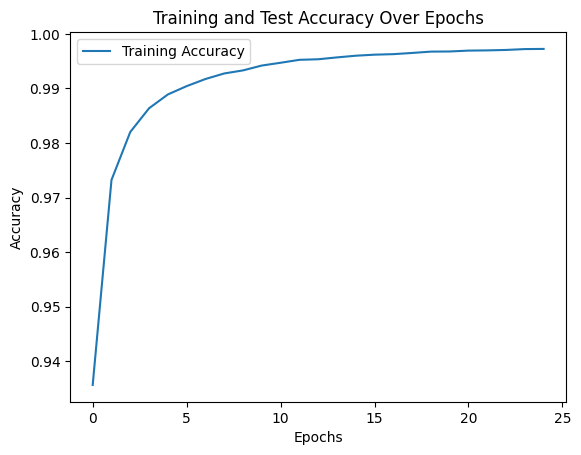

In [59]:
num_epochs = len(train_accuracies)

plt.figure()
plt.plot(np.arange(num_epochs), train_accuracies[:num_epochs], label='Training Accuracy')
# plt.plot(np.arange(num_epochs), test_accuracies[:num_epochs], label='Test Accuracy')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()

In [60]:
model_path = "./model/cnn_transformer_model_smote.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ./model/cnn_transformer_model_smote.pth


# Testing the model

In [61]:
test_df = dataframes['mitbih_test']
print(test_df.shape)

(21892, 188)


In [62]:
labels = {
    0.0: "N",
    1.0: "S",
    2.0: "V",
    3.0: "F",
    4.0: "Q"
}

test_df.iloc[:, -1] = test_df.iloc[:, -1].replace(labels)

x_data = test_df.iloc[:,:187]
y_label = test_df.iloc[:,-1]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label.values.ravel())



X = x_data
X_test = np.expand_dims(X, axis=1)  
# print(X_test.shape) 
X_test_tensor = torch.tensor(X_test).float()    
y_test_tensor = torch.tensor(y).long()        

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\randa\AppData\Local\Temp\ipykernel_51544\3926318695.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        N
1        N
2        N
3        N
4        N
        ..
21887    Q
21888    Q
21889    Q
21890    Q
21891    Q
Name: 187, Length: 21892, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_df.iloc[:, -1] = test_df.iloc[:, -1].replace(labels)


In [63]:
model.eval()

def test(model, test_loader, criterion, device):
    model.eval()  

    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to compute gradients during testing
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)         
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels


In [64]:
criterion = torch.nn.CrossEntropyLoss()  

epoch_loss, epoch_acc, all_preds, all_labels = test(model, test_loader, criterion, device)
print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")

Test Loss: 0.0920, Test Accuracy: 0.9828
